In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer as WNL

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

           Text
Sentiment      
-1         2106
 1         3685


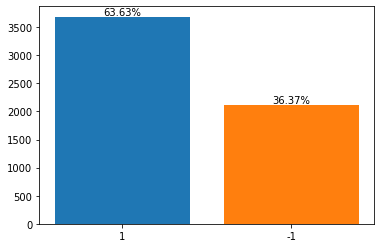

In [55]:
sentiments = pd.read_csv("/kaggle/input/stockmarket-sentiment-dataset/stock_data.csv")

# Finding out the distribution of 1s and -1s in the dataset
sentiment_count = sentiments.groupby("Sentiment").count()
print(sentiment_count)
positive = int(sentiment_count.loc[1])
percent_pos = positive / len(sentiments) * 100
negative = int(sentiment_count.loc[-1])
percent_neg = negative / len(sentiments) * 100 

fig, ax = plt.subplots()
pos = ax.bar(x="1", height=positive)
neg = ax.bar(x="-1", height=negative)
ax.bar_label(pos, labels=["%.2f" % percent_pos + "%"])
ax.bar_label(neg, labels=["%.2f" % percent_neg + "%"])
plt.show()

In [56]:
def tokenize(row):
    return [word for word in row if word not in stopwords.words("english")]

def lemmatize(row):
    return [WNL().lemmatize(word) for word in row]

def rejoin(row):
    return " ".join(row)

sentiments["Text"] = sentiments["Text"].str.lower() # converting to lower case
sentiments["Text"] = sentiments["Text"].apply(lambda row: word_tokenize(row))
    
sentiments["Text"] = sentiments["Text"].apply(lambda row: tokenize(row))
sentiments["Text"] = sentiments["Text"].apply(lambda row: lemmatize(row))

sentiments["Text"] = sentiments["Text"].apply(lambda row: rejoin(row))
sentiments.head()

,Text,Sentiment
0,kicker watchlist xide tit soq pnk cpw bpz aj t...,1
1,user : aap movie . 55 % return fea/geed indica...,1
2,user 'd afraid short amzn - looking like near-...,1
3,mnta 12.00,1
4,oi 21.37,1


In [57]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

count = CountVectorizer()
sentiments_count = count.fit_transform(sentiments.Text)

TT = TfidfTransformer()
sentiment_tfidf = TT.fit_transform(sentiments_count)

sentiment_tfidf = pd.DataFrame(sentiment_tfidf.todense())
sentiment_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,9213,9214,9215,9216,9217,9218,9219,9220,9221,9222
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.446104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Changing class -1 to 0 for xgboost
sentiments["Sentiment"] = sentiments["Sentiment"].apply(lambda x: 0 if x == -1 else 1)
sentiments.groupby("Sentiment").count()

,Text
Sentiment,
0,2106
1,3685


### Slight class imbalance, we shall compare accuracy for both stratified and non-stratified methods.

In [67]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

# 85% train, 15% test
X_train, X_test, y_train, y_test = train_test_split(sentiment_tfidf, sentiments.Sentiment, test_size=0.15, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Decreased max_depth and increased regegularisation values to help reduce overfitting.
non_stratified_model = xgb.XGBClassifier(objective="binary:logistic", max_depth=3, reg_lambda=1.1, reg_alpha=0.1)

accuracy_cv = cross_val_score(non_stratified_model, X_train, y_train, cv=kf, n_jobs=-1, scoring="accuracy")
accuracy_mean = accuracy_cv.mean()

non_stratified_model.fit(X_train, y_train)
y_predict_train = model.predict(X_train)
y_predict_test = model.predict(X_test)

train_acc = accuracy_score(y_train, y_predict_train)
test_acc = accuracy_score(y_test, y_predict_test)

print(accuracy_mean, train_acc, test_acc)

0.7486837109487846 0.8043478260869565 0.8020713463751439


In [73]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

# 85% train, 15% test
X_train, X_test, y_train, y_test = train_test_split(sentiment_tfidf, sentiments.Sentiment, test_size=0.15, shuffle=True, stratify=sentiments.Sentiment, random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Decreased max_depth and increased regegularisation values to help overfitting.
stratified_model = xgb.XGBClassifier(objective="binary:logistic", max_depth=3, reg_lambda=1.1, reg_alpha=0.1)

accuracy_cv = cross_val_score(stratified_model, X_train, y_train, cv=kf, n_jobs=-1, scoring="accuracy")
accuracy_mean = accuracy_cv.mean()

stratified_model.fit(X_train, y_train)
y_predict_train = model.predict(X_train)
y_predict_test = model.predict(X_test)

train_acc = accuracy_score(y_train, y_predict_train)
test_acc = accuracy_score(y_test, y_predict_test)

print(accuracy_mean, train_acc, test_acc)

0.751526144195452 0.8031288094270622 0.80897583429229


### Not much difference in terms of accuracy between stratified and non-stratified methods